# AI Generated to discuss with Mr. Koch

In [42]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 

In [6]:
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

In [10]:
class FruitQualityDataLoader:
    def __init__(self):
        # Define quality mappings to standardize labels
        self.quality_mappings = {
            'fresh': 0, 'good': 0, 'Fresh': 0, 'Good': 0,
            'mild': 1, 'Mild': 1,
            'rotten': 2, 'Rotten': 2, 'bad': 2, 'Bad': 2
        }
        
        self.quality_labels = ['Good/Fresh', 'Mild', 'Rotten/Bad']
    
    def display_dataset_info(self, labels, title="Dataset Statistics"):
        """Display dataset statistics with a bar plot"""
        labels_array = np.array(labels)
        
        # Print statistics
        print(f"\n{title}:")
        print(f"Total images: {len(labels)}")
        
        # Create data for plotting
        counts = []
        for idx, label in enumerate(self.quality_labels):
            count = np.sum(labels_array == idx)
            counts.append(count)
            print(f"{label}: {count} images")
        
        # Plot distribution
        plt.figure(figsize=(10, 5))
        sns.barplot(x=self.quality_labels, y=counts)
        plt.title(f"Distribution of Images Across Classes - {title}")
        plt.xlabel("Quality Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def load_zenodo_fruqdb(self, base_path):
        """Load FruQ-DB dataset"""
        fruqdb_path = Path(base_path) / 'FruQ-DB'
        return self._load_dataset(fruqdb_path, "FruQ-DB")
    
    def load_zenodo_fruqmulti(self, base_path, fruit_type=None):
        """Load FruQ-multi dataset"""
        fruqmulti_path = Path(base_path) / 'FruQ-multi'
        
        if fruit_type:
            fruit_path = fruqmulti_path / fruit_type
            if not fruit_path.exists():
                available_fruits = [f.name for f in fruqmulti_path.iterdir() if f.is_dir()]
                print("Available fruits:", available_fruits)
                raise ValueError(f"Fruit type '{fruit_type}' not found")
            return self._load_dataset(fruit_path, f"FruQ-multi - {fruit_type}")
        
        images = []
        labels = []
        fruit_types = []
        
        for fruit_dir in fruqmulti_path.iterdir():
            if fruit_dir.is_dir():
                print(f"\nLoading {fruit_dir.name}...")
                img, lbl = self._load_dataset(fruit_dir, f"FruQ-multi - {fruit_dir.name}")
                images.extend(img)
                labels.extend(lbl)
                fruit_types.extend([fruit_dir.name] * len(img))
        
        return np.array(images), np.array(labels), fruit_types
    
    def _load_dataset(self, data_path, dataset_name):
        """Internal method to load images"""
        images = []
        labels = []
        data_path = Path(data_path)
        
        quality_folders = [f for f in data_path.iterdir() if f.is_dir()]
        
        for folder in quality_folders:
            quality_name = folder.name
            if quality_name.lower() in self.quality_mappings:
                label = self.quality_mappings[quality_name]
                print(f"Processing {quality_name} (Label: {self.quality_labels[label]})...")
                
                image_files = list(folder.glob('*.jpg')) + list(folder.glob('*.jpeg')) + list(folder.glob('*.png'))
                
                for img_path in image_files:
                    try:
                        img = cv2.imread(str(img_path))
                        if img is not None:
                            images.append(img)
                            labels.append(label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
        
        if not images:
            raise ValueError(f"No images found in {data_path}")
        
        self.display_dataset_info(labels, f"Dataset: {dataset_name}")
        return np.array(images), np.array(labels)

In [11]:
def display_sample_images(images, labels, class_names, samples_per_class=5):
    """Display sample images from each class"""
    plt.figure(figsize=(15, 5*len(class_names)))
    
    for idx, class_name in enumerate(class_names):
        class_images = images[labels == idx]
        n_samples = min(samples_per_class, len(class_images))
        selected_samples = class_images[:n_samples]
        
        for i, img in enumerate(selected_samples):
            plt.subplot(len(class_names), samples_per_class, idx*samples_per_class + i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if i == 0:
                plt.ylabel(class_name, fontsize=12)
            plt.axis('off')
    
    plt.suptitle("Sample Images from Each Class", fontsize=14)
    plt.tight_layout()
    plt.show()

In [12]:
def analyze_image_properties(images):
    """Analyze and display image properties"""
    sizes = []
    aspect_ratios = []
    
    for img in images:
        h, w = img.shape[:2]
        sizes.append((w, h))
        aspect_ratios.append(w/h)
    
    # Plot size distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.scatter([s[0] for s in sizes], [s[1] for s in sizes], alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Dimensions Distribution')
    
    plt.subplot(122)
    plt.hist(aspect_ratios, bins=50)
    plt.xlabel('Aspect Ratio (width/height)')
    plt.ylabel('Count')
    plt.title('Aspect Ratio Distribution')
    
    plt.tight_layout()
    plt.show()

Loading FruQ-DB dataset...
Processing Fresh (Label: Good/Fresh)...
Processing Mild (Label: Mild)...
Processing Rotten (Label: Rotten/Bad)...

Dataset: FruQ-DB:
Total images: 5647
Good/Fresh: 2182 images
Mild: 1364 images
Rotten/Bad: 2101 images


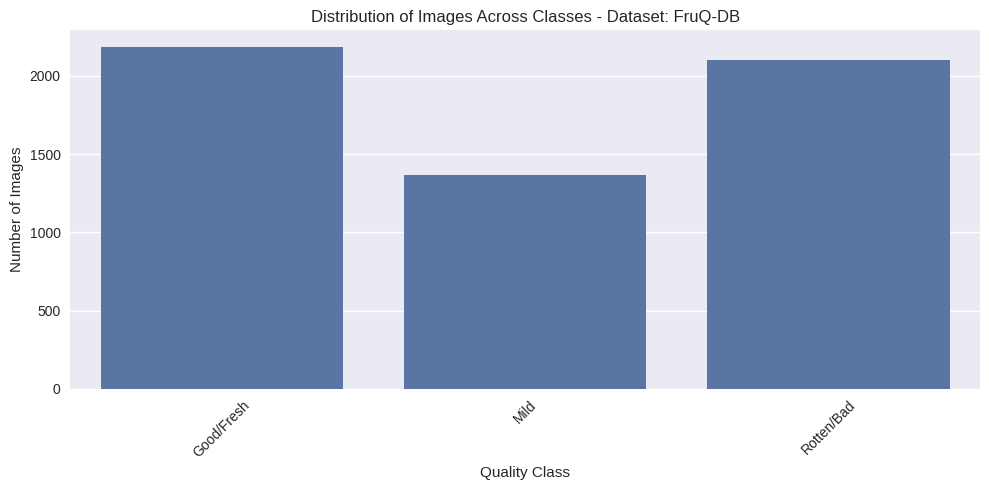


Displaying sample images from FruQ-DB:


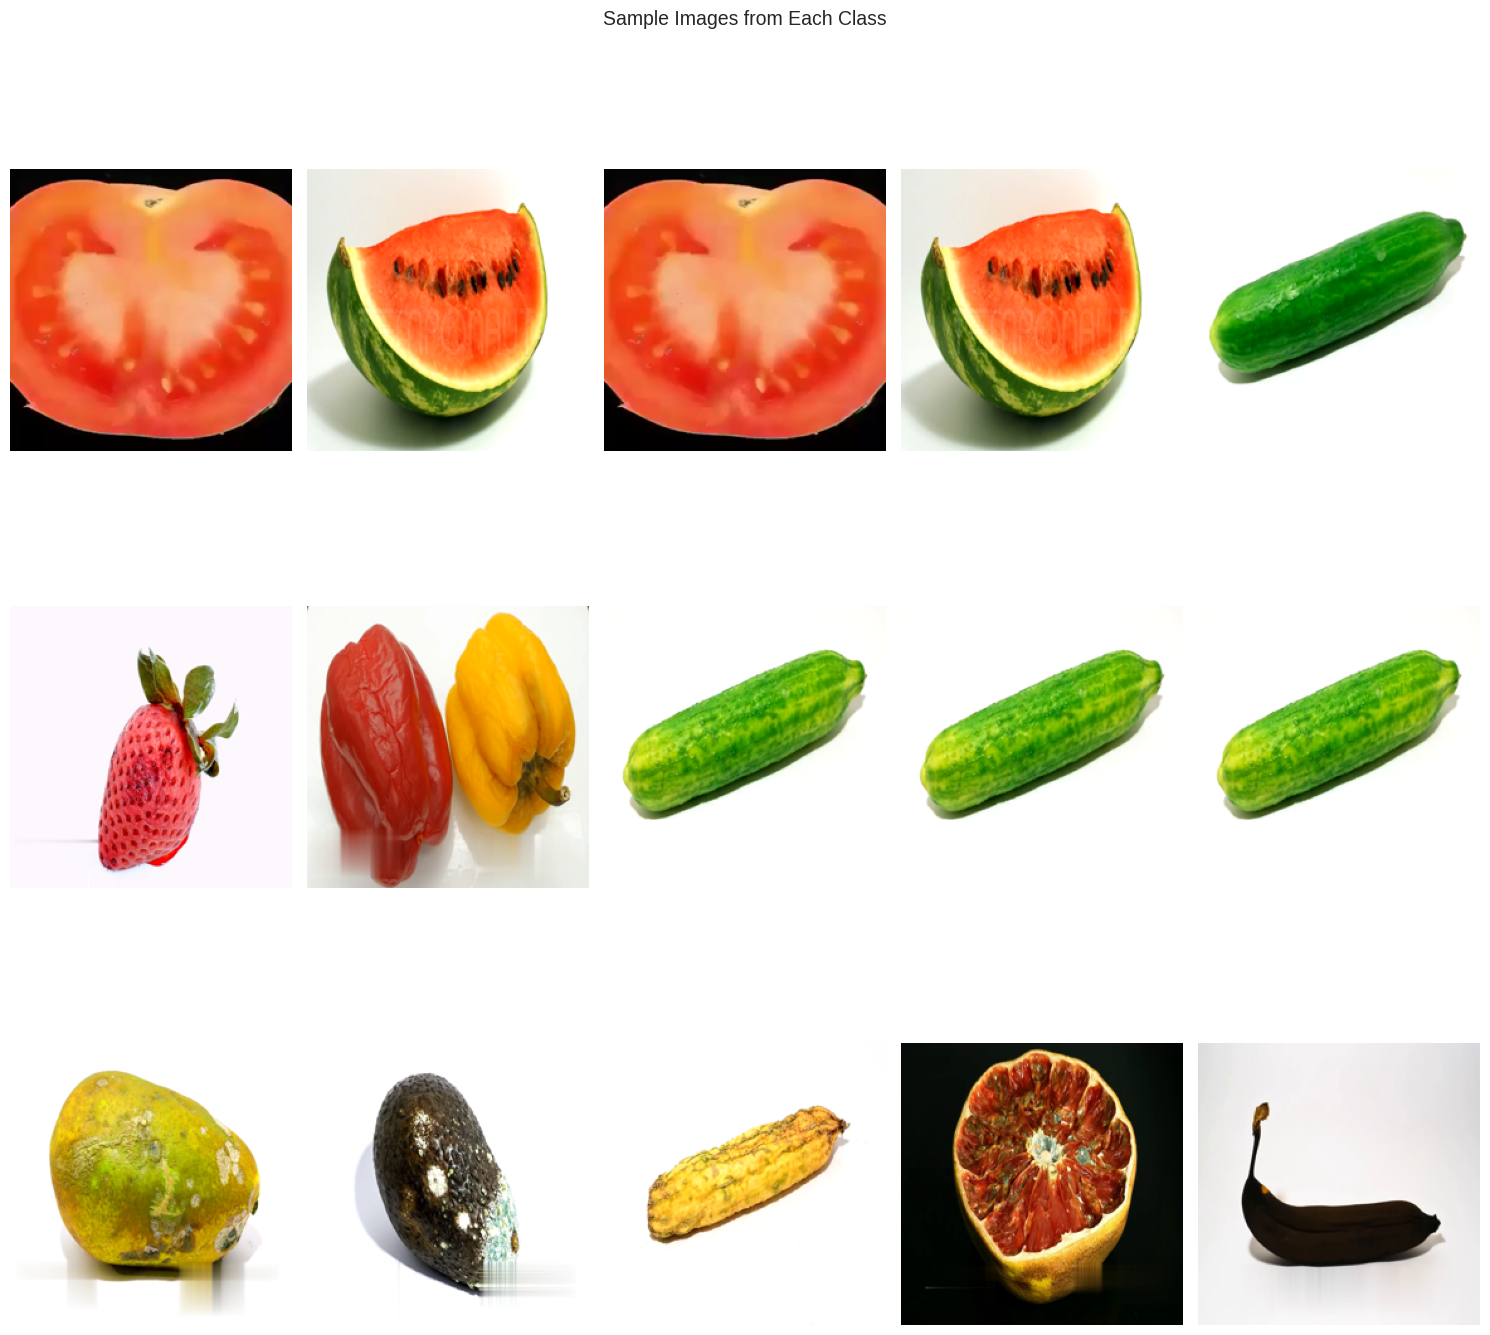


Analyzing image properties for FruQ-DB:


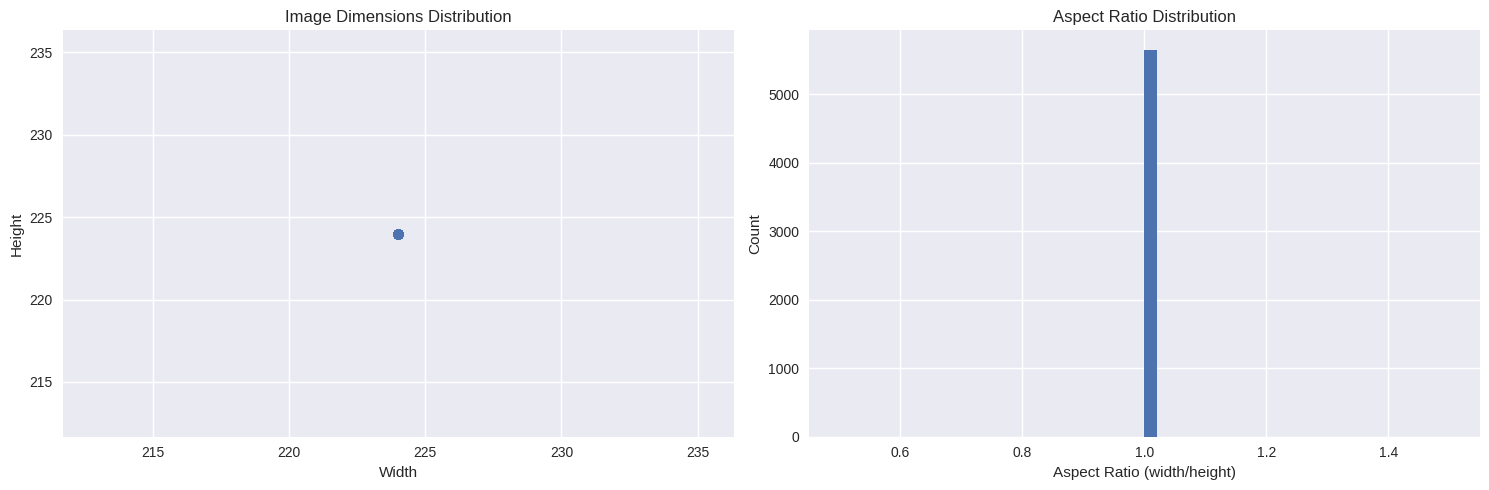

In [19]:
# Initialize the loader
loader = FruitQualityDataLoader()

# Set the base path to your dataset
base_path = 'fruit_datasets/zenodo_data'  # Update this path as needed

# Load FruQ-DB dataset
print("Loading FruQ-DB dataset...")
fruqdb_images, fruqdb_labels = loader.load_zenodo_fruqdb(base_path)

# Display sample images
print("\nDisplaying sample images from FruQ-DB:")
display_sample_images(fruqdb_images, fruqdb_labels, loader.quality_labels)

# Analyze image properties
print("\nAnalyzing image properties for FruQ-DB:")
analyze_image_properties(fruqdb_images)


Loading Banana dataset from FruQ-multi...
Processing Good (Label: Good/Fresh)...
Processing mild (Label: Mild)...
Processing Rotten (Label: Rotten/Bad)...

Dataset: FruQ-multi - BananaDB:
Total images: 612
Good/Fresh: 179 images
Mild: 96 images
Rotten/Bad: 337 images


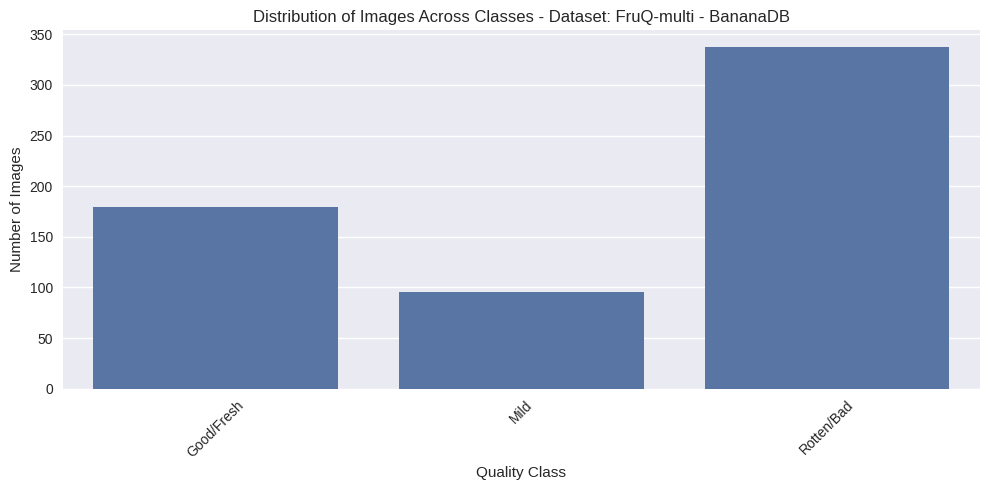

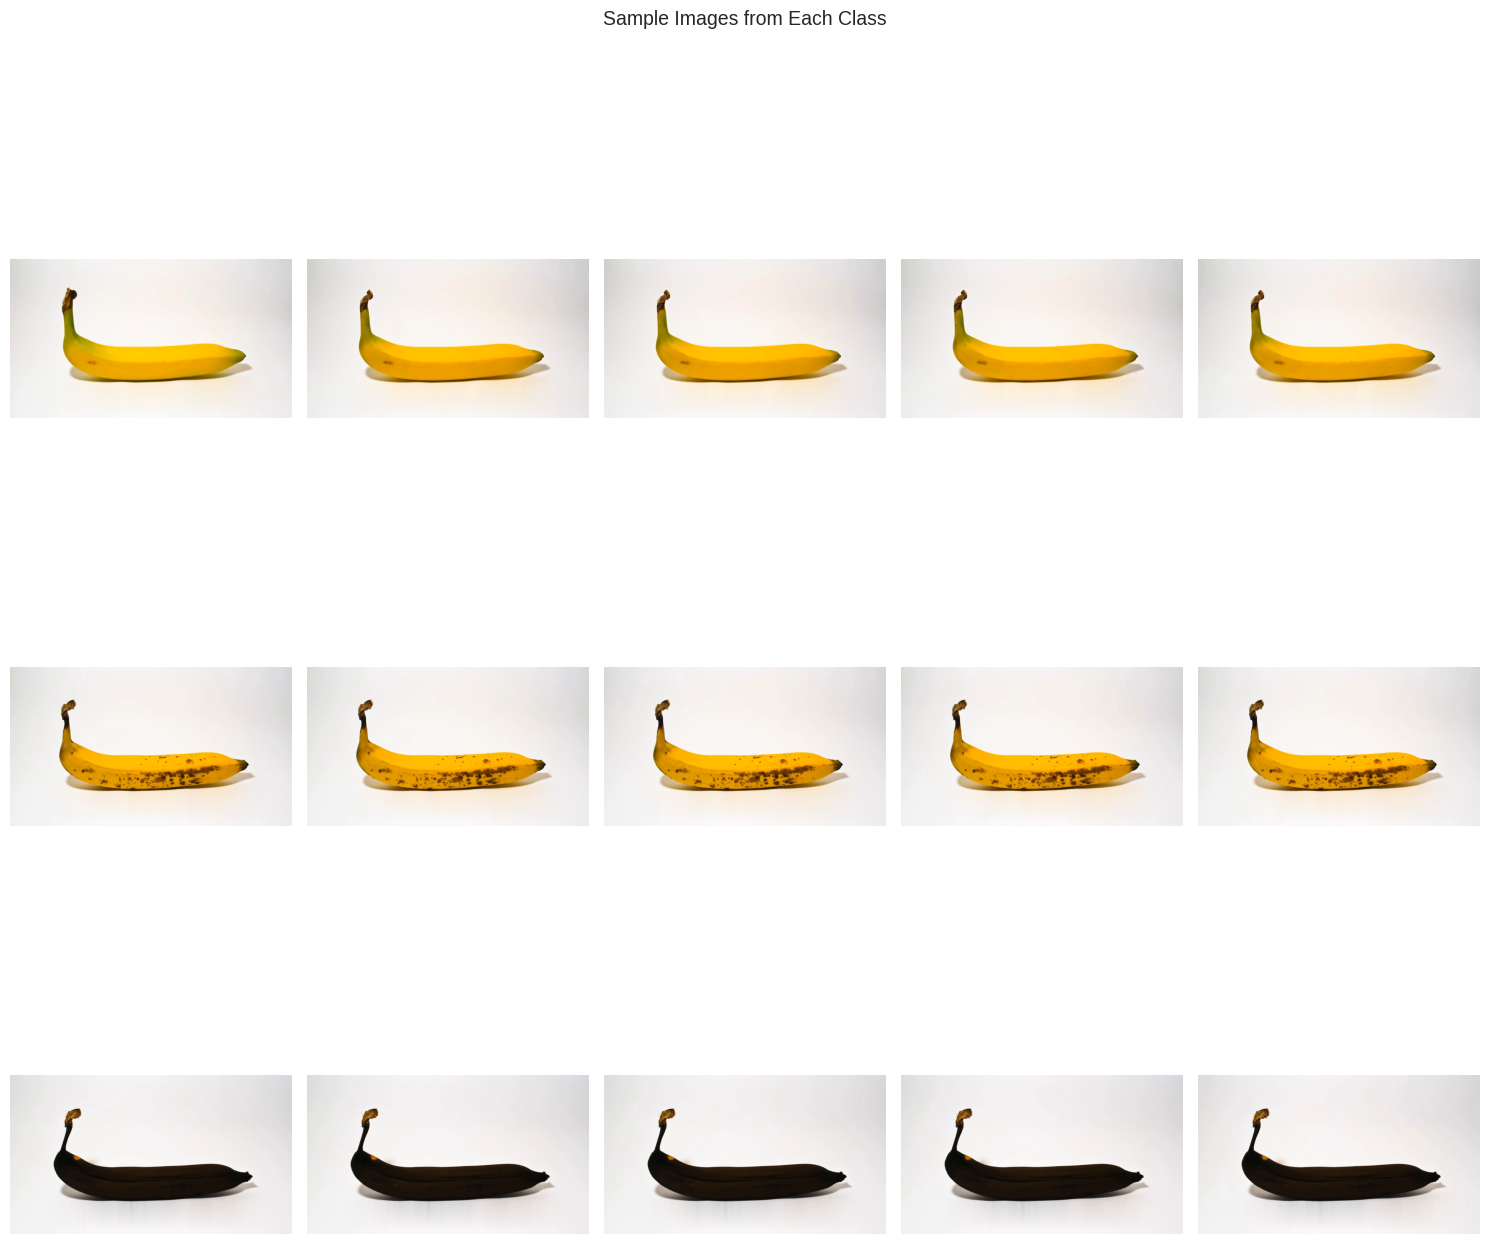

In [20]:
# Load specific fruit data (e.g., Banana)
print("\nLoading Banana dataset from FruQ-multi...")
banana_images, banana_labels = loader.load_zenodo_fruqmulti(base_path, fruit_type='BananaDB')

# Display sample images
display_sample_images(banana_images, banana_labels, loader.quality_labels)

In [23]:
fruqmulti_path = Path(base_path) / 'FruQ-multi'
available_fruits = [f.name for f in fruqmulti_path.iterdir() if f.is_dir()]
print("\nAvailable fruits in FruQ-multi:")
for fruit in available_fruits:
    print(f"- {fruit}")


Available fruits in FruQ-multi:
- FruQ-multi
- BananaDB
- CucumberQ
- GrapeQ
- KakiQ
- PapayaQ
- PeachQ
- PearQ
- PepperQ
- StrawberryQ
- tomatoQ
- WatermeloQ


In [29]:
# Cell 8: Define preprocessing functions
def preprocess_image(image, target_size=(224, 224), visualize=True):
    """
    Implement preprocessing steps using HSV color space
    """
    # Store intermediate results for visualization
    steps = []
    
    # Step 1: Resize to uniform size
    resized = cv2.resize(image, target_size)
    steps.append(('Original RGB', cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)))
    
    # Step 2: Convert to HSV
    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    steps.append(('HSV', hsv))
    
    # Split HSV channels
    h, s, v = cv2.split(hsv)
    steps.append(('Hue', h))
    steps.append(('Saturation', s))
    steps.append(('Value', v))
    
    # Step 3: Histogram equalization on V channel
    v_eq = cv2.equalizeHist(v)
    steps.append(('Equalized Value', v_eq))
    
    # Step 4: Otsu's thresholding on equalized V channel
    _, thresh = cv2.threshold(v_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    steps.append(('Thresholded', thresh))
    
    if visualize:
        plt.figure(figsize=(20, 8))
        for idx, (name, img) in enumerate(steps):
            plt.subplot(2, 4, idx + 1)
            if name == 'HSV':
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
            else:
                plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            plt.title(name)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Display HSV channel histograms
        plt.figure(figsize=(15, 4))
        colors = ['b', 'g', 'r']
        channels = ['Hue', 'Saturation', 'Value']
        for idx, (channel, color) in enumerate(zip([h, s, v], colors)):
            plt.subplot(1, 3, idx + 1)
            plt.hist(channel.ravel(), bins=256, color=color)
            plt.title(f'{channels[idx]} Histogram')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    
    # Return HSV channels and threshold for feature extraction
    return {
        'hsv': hsv,
        'hue': h,
        'saturation': s,
        'value': v,
        'value_eq': v_eq,
        'threshold': thresh
    }

In [30]:
def extract_features(preprocessed_output, visualize=True):
    """
    Extract features from HSV channels and shape
    """
    features = []
    
    # 1. Color Features from HSV
    h_hist, _ = np.histogram(preprocessed_output['hue'].ravel(), bins=30, range=(0, 180))
    s_hist, _ = np.histogram(preprocessed_output['saturation'].ravel(), bins=30, range=(0, 256))
    v_hist, _ = np.histogram(preprocessed_output['value'].ravel(), bins=30, range=(0, 256))
    
    # Normalize histograms
    h_hist = h_hist.astype('float') / h_hist.sum()
    s_hist = s_hist.astype('float') / s_hist.sum()
    v_hist = v_hist.astype('float') / v_hist.sum()
    
    features.extend(h_hist)
    features.extend(s_hist)
    features.extend(v_hist)
    
    # 2. Texture Features using LBP on Value channel
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(preprocessed_output['value'], n_points, radius, method='uniform')
    
    # Calculate LBP histogram
    n_bins = n_points + 2
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype('float') / lbp_hist.sum()
    features.extend(lbp_hist)
    
    # 3. Shape Features using contours
    contours, _ = cv2.findContours(preprocessed_output['threshold'], 
                                 cv2.RETR_EXTERNAL, 
                                 cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        
        # Add moment-based features
        moments = cv2.moments(largest_contour)
        hu_moments = cv2.HuMoments(moments)
        shape_features = [area, perimeter, circularity]
        shape_features.extend(hu_moments.flatten())
    else:
        shape_features = [0] * 10  # Area, perimeter, circularity, and 7 Hu moments
    
    features.extend(shape_features)
    
    if visualize:
        # Visualize HSV channels and their histograms
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        channels = ['Hue', 'Saturation', 'Value']
        hists = [h_hist, s_hist, v_hist]
        imgs = [preprocessed_output['hue'], 
               preprocessed_output['saturation'], 
               preprocessed_output['value']]
        
        for idx, (channel, hist, img) in enumerate(zip(channels, hists, imgs)):
            # Show channel
            axes[0, idx].imshow(img, cmap='gray')
            axes[0, idx].set_title(f'{channel} Channel')
            axes[0, idx].axis('off')
            
            # Show histogram
            axes[1, idx].bar(range(len(hist)), hist)
            axes[1, idx].set_title(f'{channel} Histogram')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize LBP
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(preprocessed_output['value'], cmap='gray')
        plt.title('Value Channel')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(lbp, cmap='gray')
        plt.title('LBP')
        plt.axis('off')
        
        plt.subplot(133)
        plt.bar(range(len(lbp_hist)), lbp_hist)
        plt.title('LBP Histogram')
        
        plt.tight_layout()
        plt.show()
        
        if contours:
            plt.figure(figsize=(8, 4))
            contour_img = cv2.cvtColor(preprocessed_output['value'].copy(), cv2.COLOR_GRAY2BGR)
            cv2.drawContours(contour_img, [largest_contour], -1, (0, 255, 0), 2)
            plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
            plt.title('Detected Contours')
            plt.axis('off')
            plt.show()
            
            print("\nShape Features:")
            print(f"Area: {area:.2f}")
            print(f"Perimeter: {perimeter:.2f}")
            print(f"Circularity: {circularity:.2f}")
    
    return np.array(features)

Processing example image with new HSV-based pipeline...


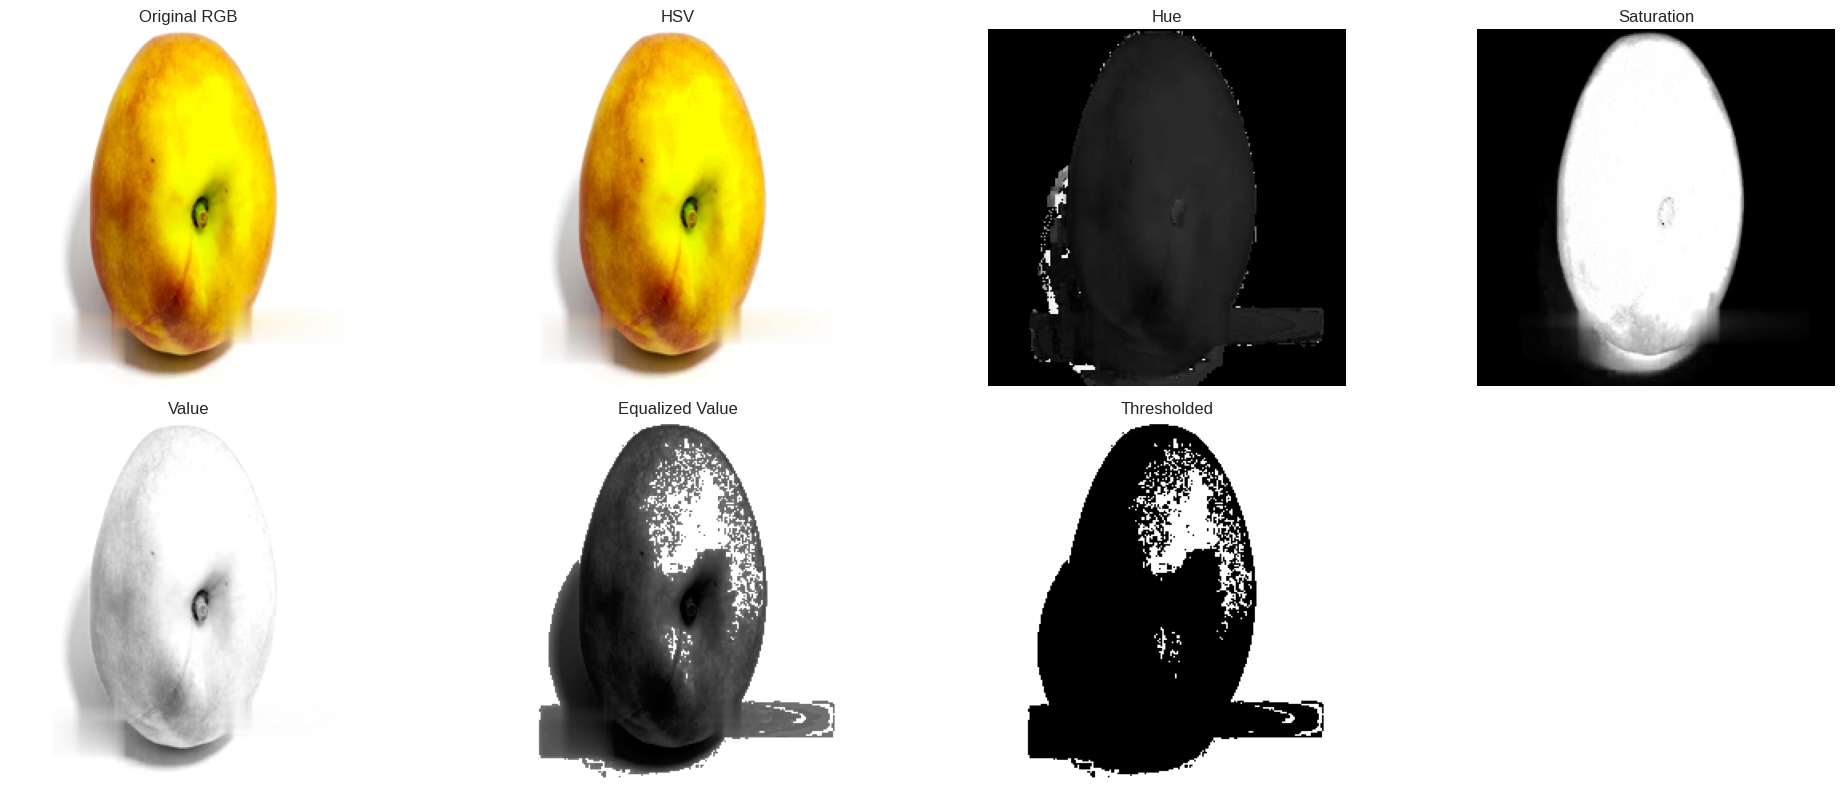

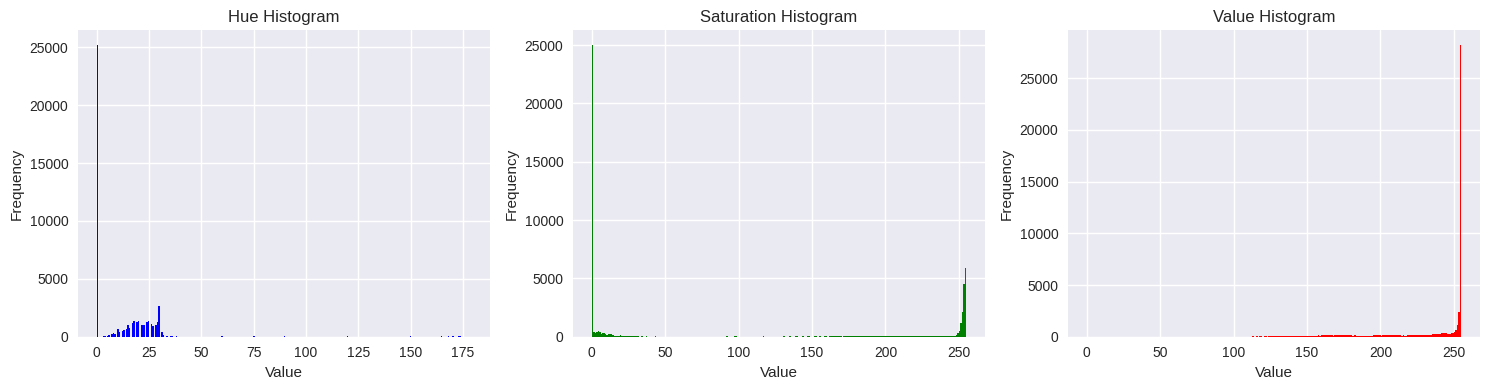

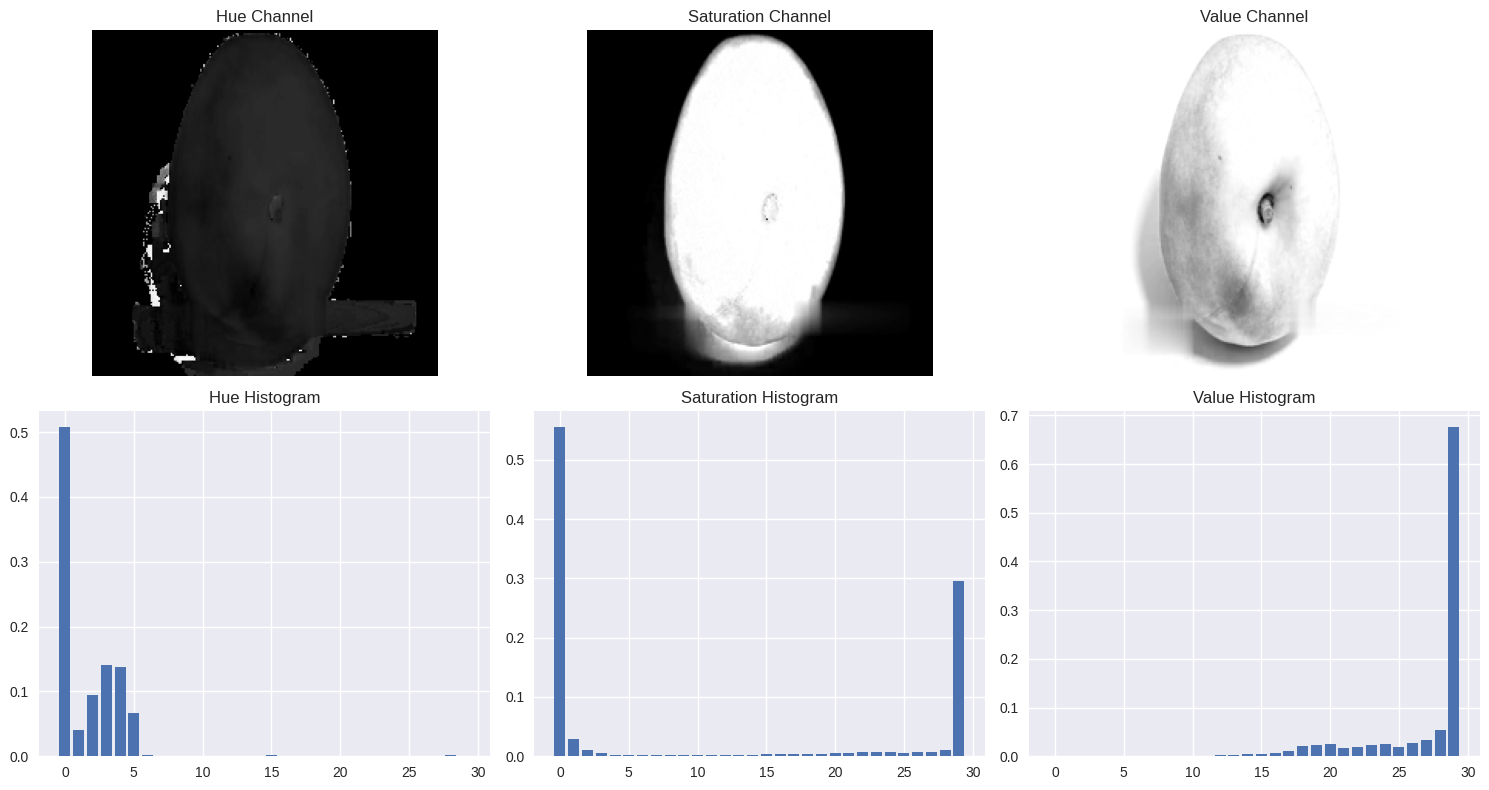

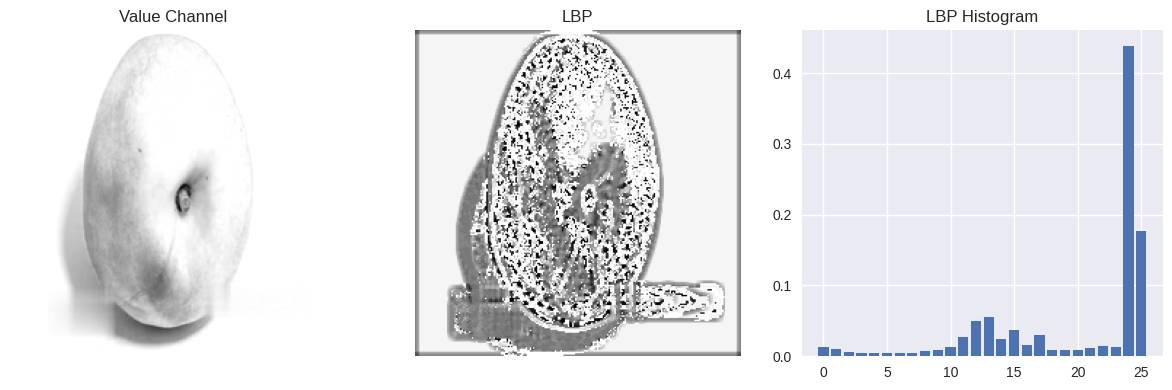

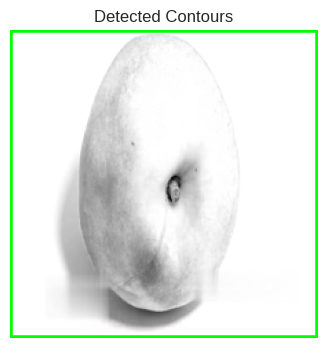


Shape Features:
Area: 49729.00
Perimeter: 892.00
Circularity: 0.79

Extracted feature vector length: 126

Feature vector composition:
- HSV histograms: 90 features (30 per channel)
- LBP features: 26 features
- Shape features: 10 features (area, perimeter, circularity, 7 Hu moments)


In [36]:
# Get an example image from the dataset
example_idx = 7  # Change this to view different images
example_image = fruqdb_images[example_idx]

print("Processing example image with new HSV-based pipeline...")
preprocessed = preprocess_image(example_image)
features = extract_features(preprocessed)

print(f"\nExtracted feature vector length: {len(features)}")
print("\nFeature vector composition:")
print(f"- HSV histograms: 90 features (30 per channel)")
print(f"- LBP features: {8 * 3 + 2} features")
print(f"- Shape features: 10 features (area, perimeter, circularity, 7 Hu moments)")

In [26]:
def process_dataset(images, target_size=(224, 224)):
    """
    Process all images and extract features
    """
    features_list = []
    processed_images = []
    
    for i, image in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
            
        # Preprocess image
        preprocessed = preprocess_image(image, target_size=target_size, visualize=True)
        processed_images.append(preprocessed)
        
        # Extract features
        features = extract_features(preprocessed, visualize=False)
        features_list.append(features)
    
    return np.array(processed_images), np.array(features_list)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_pca(features, n_components=100):
    """
    Apply PCA for dimensionality reduction
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot explained variance ratio
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    
    plt.subplot(122)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Individual Component Contribution')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal explained variance with {n_components} components: "
          f"{np.sum(pca.explained_variance_ratio_):.3f}")
    
    return features_pca, scaler, pca

In [ ]:
print("Processing FruQ-DB dataset...")
processed_images, features = process_dataset(fruqdb_images)

# Show example of preprocessing and feature extraction for one image
example_idx = 0  # Change this to view different images
print("\nExample preprocessing and feature extraction for one image:")
preprocessed = preprocess_image(fruqdb_images[example_idx])
features = extract_features(preprocessed)

# Apply PCA
print("\nApplying PCA to extracted features...")
features_pca, scaler, pca = apply_pca(features)

In [37]:
# Cell 11: Import required libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [38]:
def prepare_data(features, labels):
    """
    Prepare data for training by splitting and scaling
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a single model
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Print results
    print(f"\n{model_name} Results:")
    print("Cross-validation scores:", cv_scores)
    print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                              target_names=['Good/Fresh', 'Mild', 'Rotten/Bad']))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good/Fresh', 'Mild', 'Rotten/Bad'],
                yticklabels=['Good/Fresh', 'Mild', 'Rotten/Bad'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return model, y_pred

In [39]:
# Cell 13: Define and train all models
def train_all_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate all classifiers
    """
    models = {
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=1),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': GaussianNB(),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), 
                                      max_iter=1000,
                                      random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        trained_model, predictions = train_and_evaluate_model(
            model, X_train, X_test, y_train, y_test, name
        )
        results[name] = {
            'model': trained_model,
            'predictions': predictions
        }
    
    return results

In [40]:
def compare_models(results, y_test):
    """
    Compare performance of all models
    """
    # Prepare data for comparison
    model_scores = []
    for name, result in results.items():
        predictions = result['predictions']
        accuracy = np.mean(predictions == y_test)
        model_scores.append({
            'Model': name,
            'Accuracy': accuracy
        })
    
    # Create comparison plot
    plt.figure(figsize=(10, 6))
    scores_df = pd.DataFrame(model_scores)
    sns.barplot(x='Model', y='Accuracy', data=scores_df)
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return scores_df

Processing entire dataset...

Preparing data for training...

Training and evaluating all models...

Training K-Nearest Neighbors...

K-Nearest Neighbors Results:
Cross-validation scores: [0.99889381 1.         0.99667774 0.99889258 0.99778516]
Average CV score: 0.998 (+/- 0.002)

Classification Report:
              precision    recall  f1-score   support

  Good/Fresh       1.00      1.00      1.00       437
        Mild       1.00      1.00      1.00       273
  Rotten/Bad       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



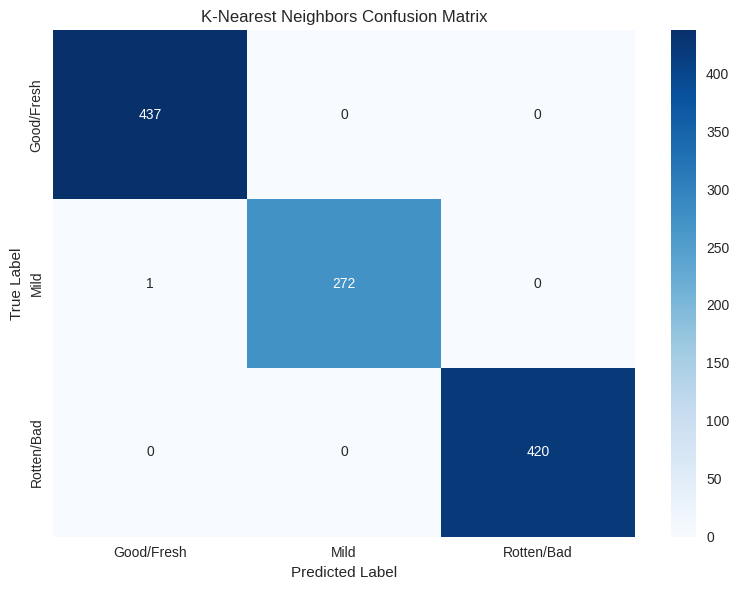


Training Logistic Regression...

Logistic Regression Results:
Cross-validation scores: [0.99889381 0.99778761 0.99778516 0.99114064 0.99557032]
Average CV score: 0.996 (+/- 0.006)

Classification Report:
              precision    recall  f1-score   support

  Good/Fresh       1.00      1.00      1.00       437
        Mild       1.00      0.99      0.99       273
  Rotten/Bad       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



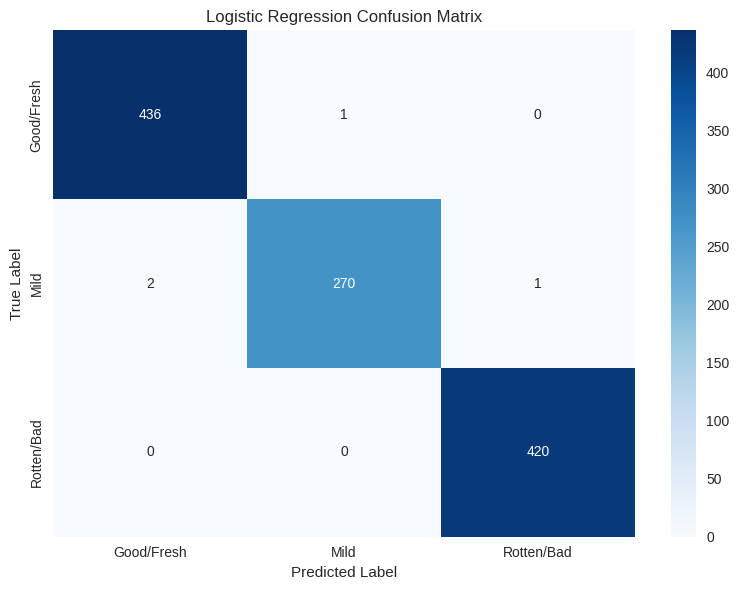


Training Naive Bayes...

Naive Bayes Results:
Cross-validation scores: [0.67367257 0.71681416 0.7076412  0.70099668 0.70431894]
Average CV score: 0.701 (+/- 0.029)

Classification Report:
              precision    recall  f1-score   support

  Good/Fresh       0.78      0.76      0.77       437
        Mild       0.49      0.78      0.60       273
  Rotten/Bad       0.92      0.58      0.71       420

    accuracy                           0.70      1130
   macro avg       0.73      0.71      0.69      1130
weighted avg       0.76      0.70      0.71      1130



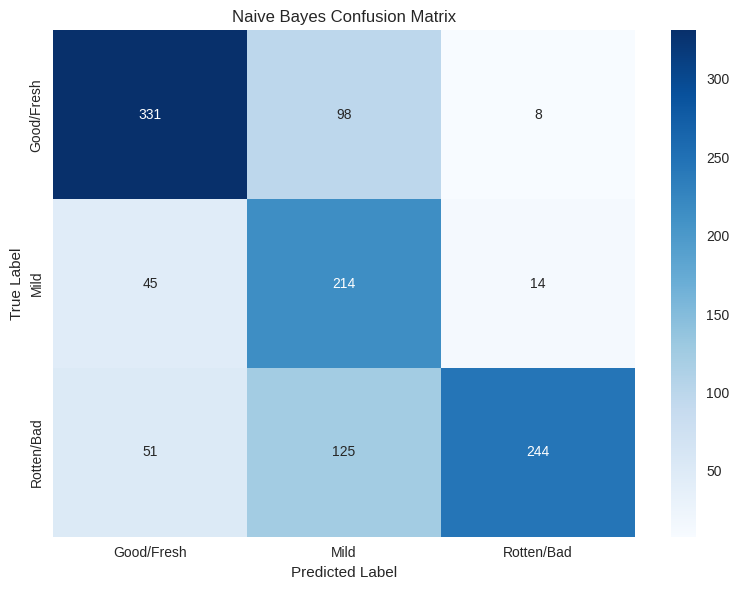


Training Neural Network...

Neural Network Results:
Cross-validation scores: [0.99889381 1.         0.99778516 0.99778516 0.99889258]
Average CV score: 0.999 (+/- 0.002)

Classification Report:
              precision    recall  f1-score   support

  Good/Fresh       1.00      1.00      1.00       437
        Mild       1.00      1.00      1.00       273
  Rotten/Bad       1.00      1.00      1.00       420

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130



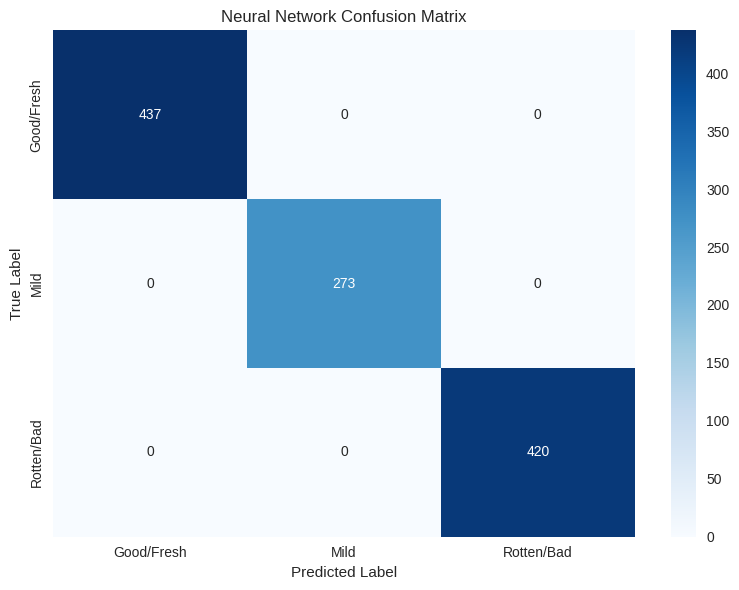


Comparing model performances...


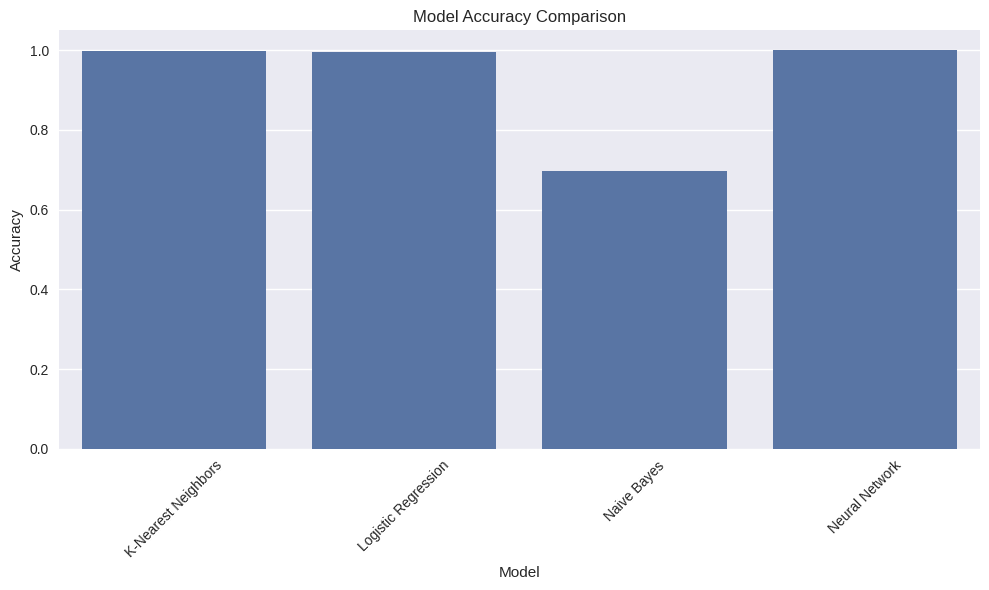


Overall Performance Summary:
                 Model  Accuracy
0  K-Nearest Neighbors  0.999115
1  Logistic Regression  0.996460
2          Naive Bayes  0.698230
3       Neural Network  1.000000


In [43]:
# Get features for the entire dataset
print("Processing entire dataset...")
# Assuming we have loaded fruqdb_images and fruqdb_labels from previous cells
all_preprocessed = [preprocess_image(img, visualize=False) for img in fruqdb_images]
all_features = [extract_features(prep, visualize=False) for prep in all_preprocessed]
features_array = np.array(all_features)

# Prepare data
print("\nPreparing data for training...")
X_train, X_test, y_train, y_test, scaler = prepare_data(features_array, fruqdb_labels)

# Train and evaluate all models
print("\nTraining and evaluating all models...")
model_results = train_all_models(X_train, X_test, y_train, y_test)

# Compare model performances
print("\nComparing model performances...")
performance_comparison = compare_models(model_results, y_test)
print("\nOverall Performance Summary:")
print(performance_comparison)

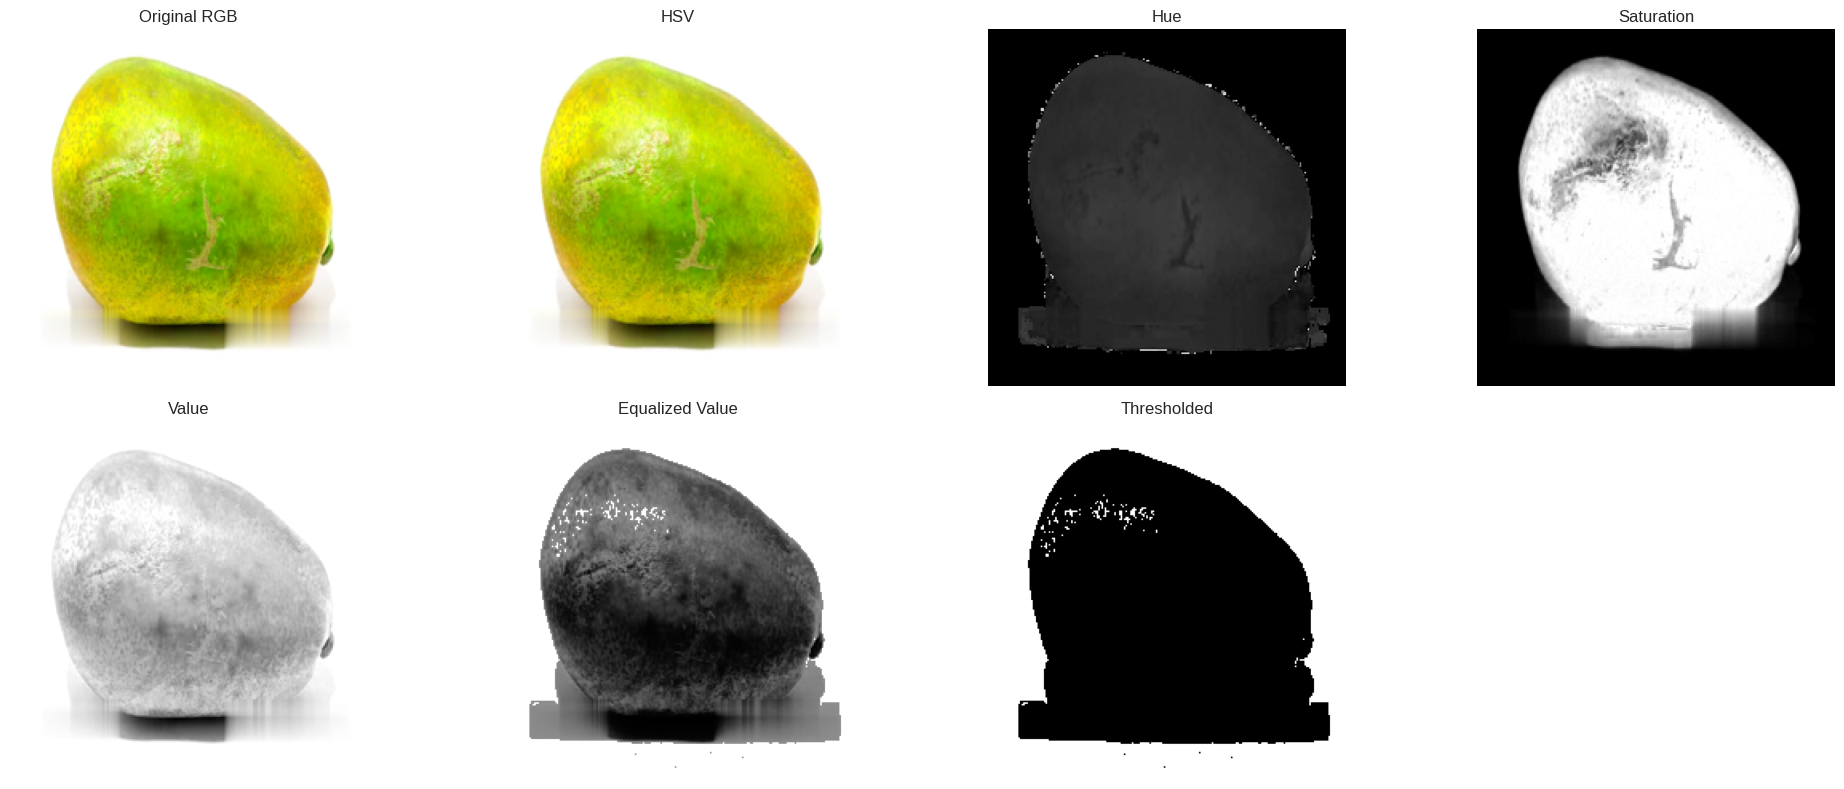

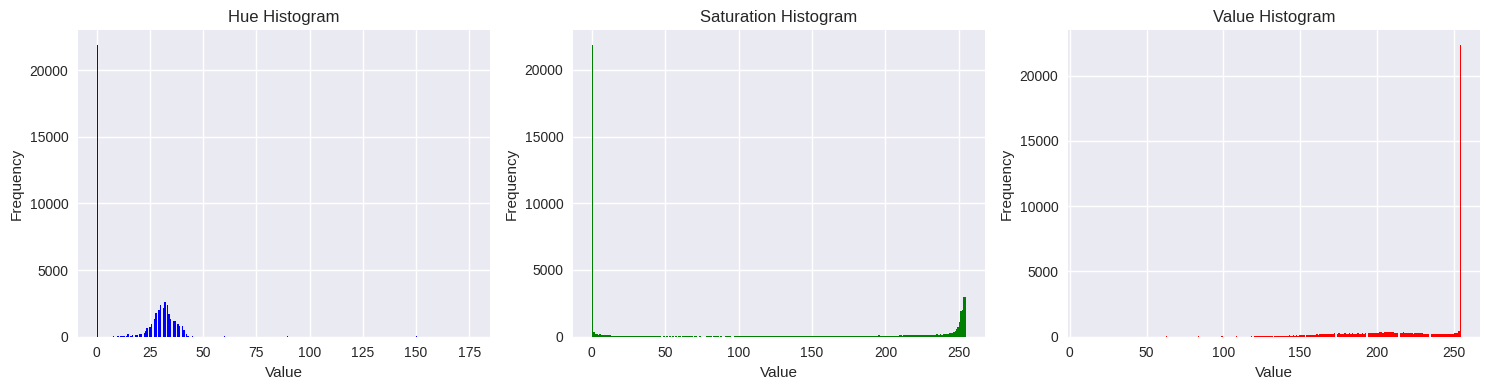

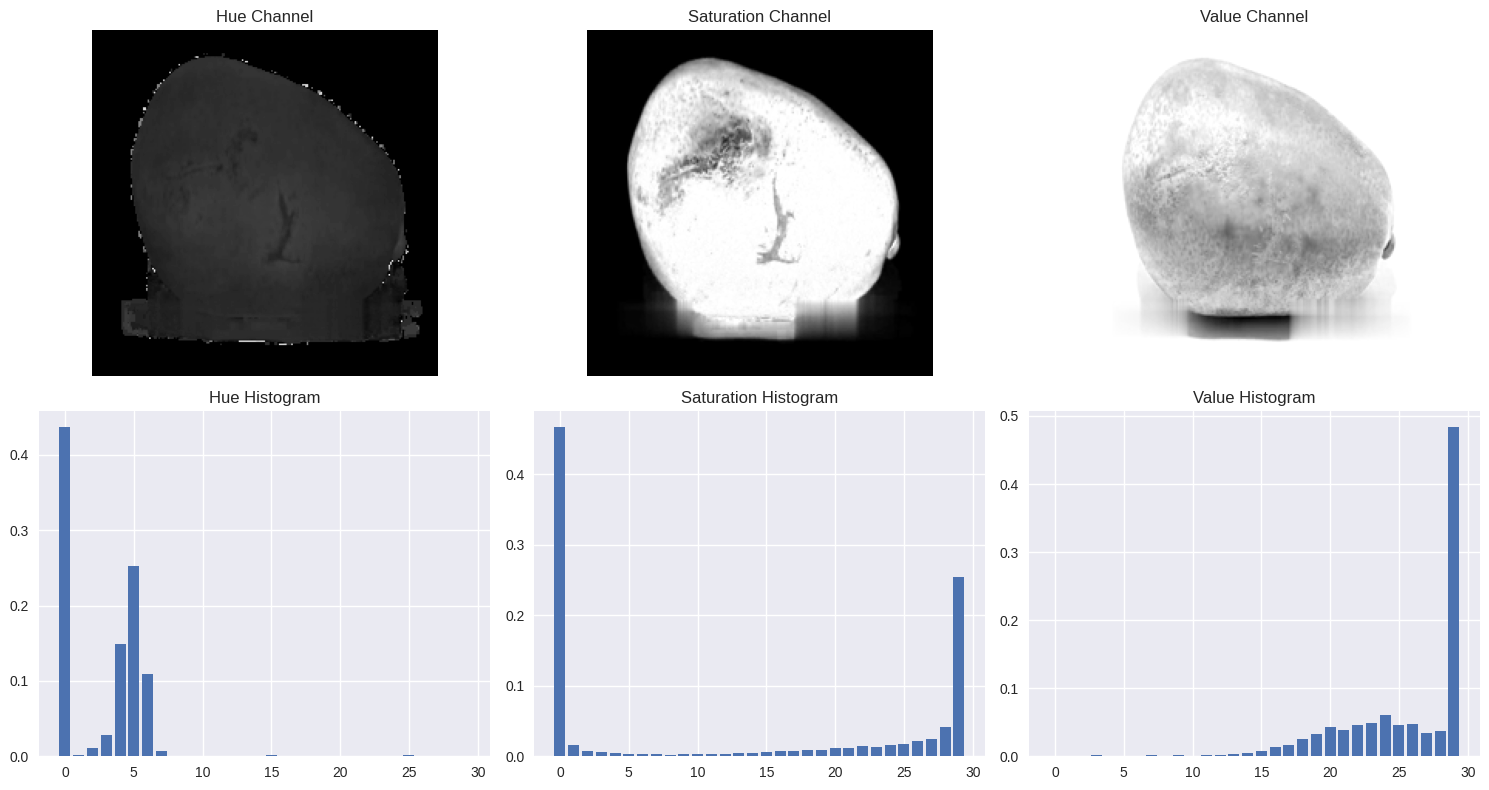

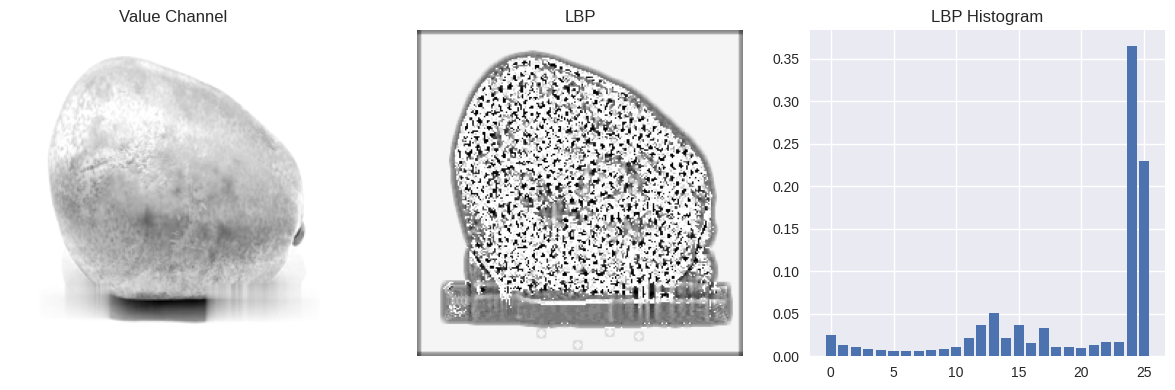

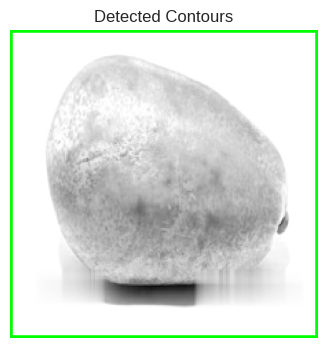


Shape Features:
Area: 49729.00
Perimeter: 892.00
Circularity: 0.79


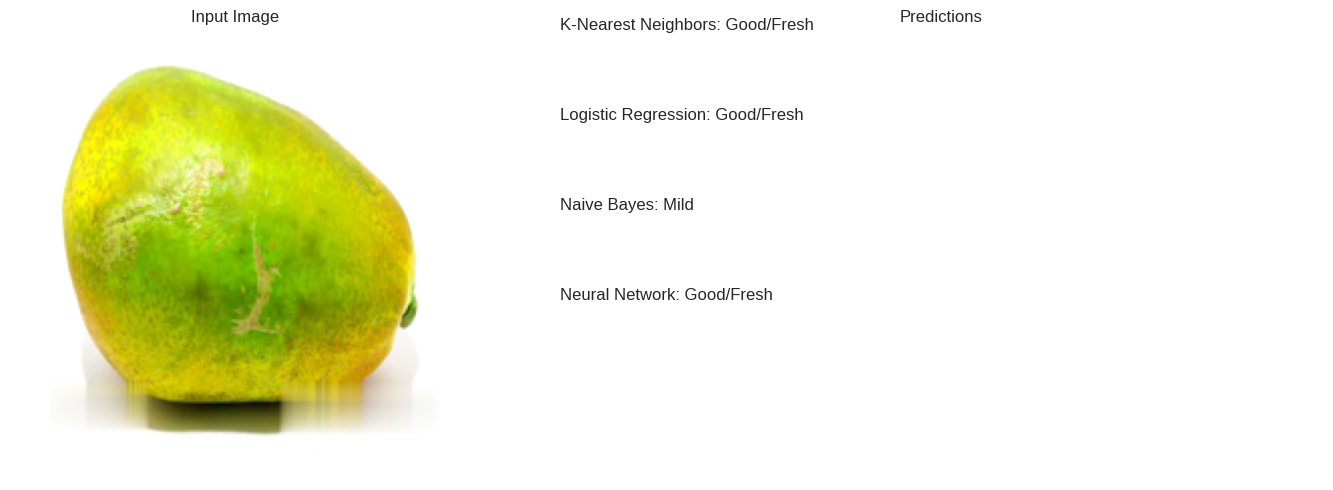

In [58]:
# Cell 16: Function to predict new images
def predict_fruit_quality(image, model_results, scaler):
    """
    Predict quality of a new fruit image using all trained models
    """
    # Preprocess the image
    preprocessed = preprocess_image(image)
    features = extract_features(preprocessed)
    
    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Get predictions from all models
    predictions = {}
    for name, result in model_results.items():
        model = result['model']
        pred = model.predict(features_scaled)[0]
        predictions[name] = ['Good/Fresh', 'Mild', 'Rotten/Bad'][pred]
    
    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i, (model, prediction) in enumerate(predictions.items()):
        plt.text(0, 1 - i*0.2, f'{model}: {prediction}', fontsize=12)
    plt.axis('off')
    plt.title('Predictions')
    plt.tight_layout()
    plt.show()
    
    return predictions

# Example usage for a test image
test_idx =  89 # Use last image in test set
test_image = fruqdb_images[test_idx]
predictions = predict_fruit_quality(test_image, model_results, scaler)